In [161]:
#Author: Aaron Hertner
#Version: Python Base 3.8
#Purpose: To expand on concepts learned from results of previous Anomaly Detection experiments

In [162]:
import warnings

#graphing and util
from matplotlib.cbook import mplDeprecation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sb
from collections import Counter
import time
from ipywidgets import interact, interactive
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

#ML Libraries
from sklearn.model_selection import train_test_split

#ML Models
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore",category=mplDeprecation)

In [163]:
data = pd.read_csv('../_datasets/annthyroid_21feat_normalised.csv')

pd.options.display.max_columns = None
data.head()

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,Dim_10=0,Dim_11=0,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,class
0,0.750000,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0.001132,0.080780,0.197324,0.300926,0.225000,0
1,0.239583,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.000472,0.164345,0.235786,0.537037,0.165625,0
2,0.479167,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.003585,0.130919,0.167224,0.527778,0.118750,0
3,0.656250,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.001698,0.091922,0.125418,0.337963,0.129688,0
4,0.229167,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.000472,0.142061,0.229097,0.337963,0.235938,0


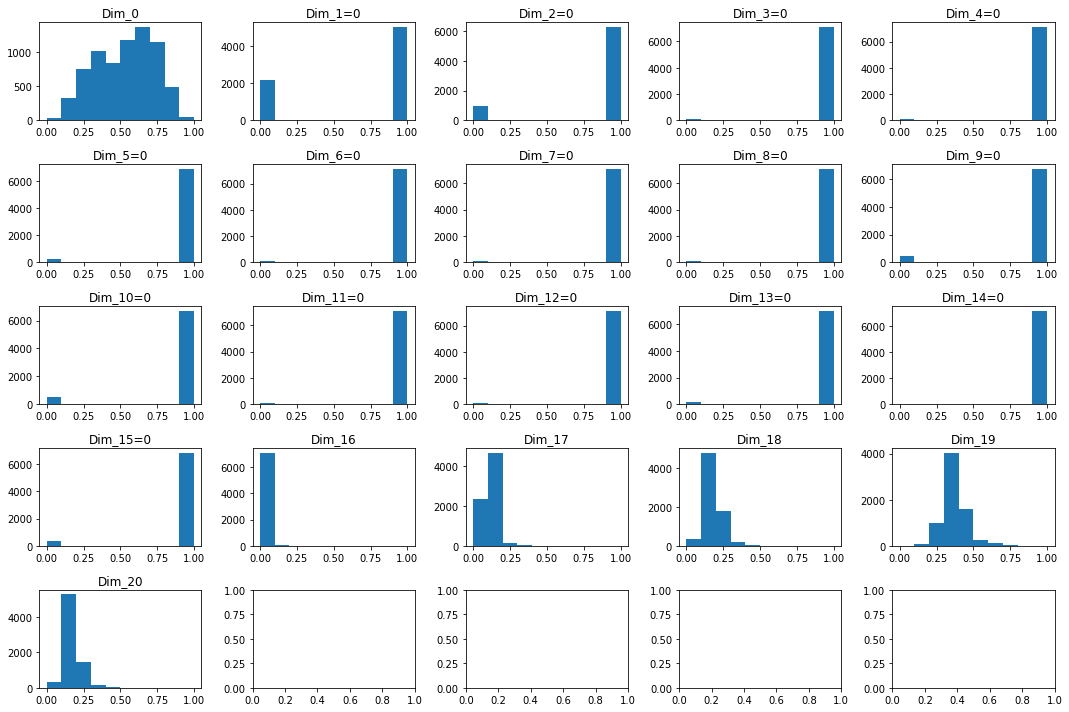

In [164]:
#histograms of features
fig, axarr = plt.subplots(5,5, figsize=(15,10))

Y = data['class']
X = data.drop(['class'], axis=1)

i = 0
for col in X.columns:
        axarr[i//5][i%5].hist(X[col])
        axarr[i//5][i%5].set_title(col)
        i += 1
        
plt.tight_layout()

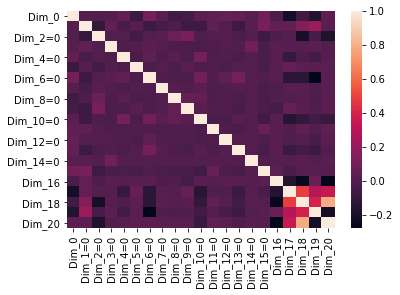

In [165]:
sb.heatmap(X.corr())

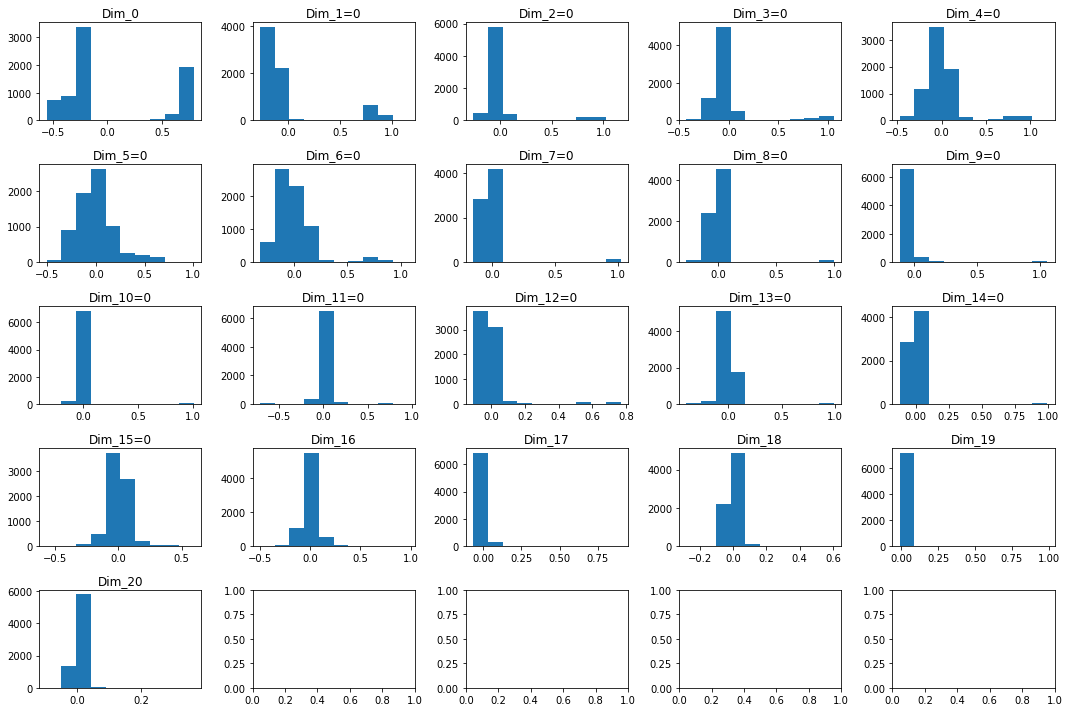

In [166]:
#histograms of features
fig, axarr = plt.subplots(5,5, figsize=(15,10))

Y = data['class']
X = data.drop(['class'], axis=1)

#apply PCA
pca = PCA()
X = pd.DataFrame(pca.fit_transform(X), columns = X.columns)

i = 0
for col in X.columns:
        axarr[i//5][i%5].hist(X[col])
        axarr[i//5][i%5].set_title(col)
        i += 1
        
plt.tight_layout()

In [167]:
X.isnull().sum()

Dim_0       0
Dim_1=0     0
Dim_2=0     0
Dim_3=0     0
Dim_4=0     0
Dim_5=0     0
Dim_6=0     0
Dim_7=0     0
Dim_8=0     0
Dim_9=0     0
Dim_10=0    0
Dim_11=0    0
Dim_12=0    0
Dim_13=0    0
Dim_14=0    0
Dim_15=0    0
Dim_16      0
Dim_17      0
Dim_18      0
Dim_19      0
Dim_20      0
dtype: int64

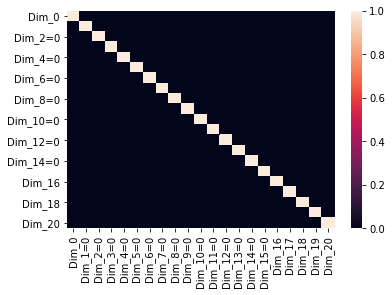

In [168]:
sb.heatmap(X.corr())

(7200, 5)


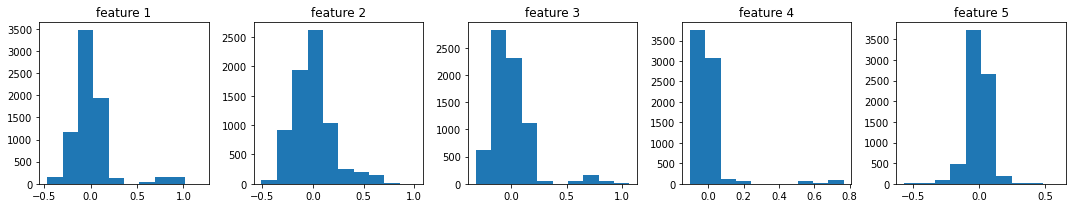

In [169]:
#drop non-gaussian features
X = X.loc[:, ['Dim_4=0', 
              'Dim_5=0', 
              'Dim_6=0', 
              'Dim_12=0', 
              'Dim_15=0']]

print(X.shape)

fig, axarr = plt.subplots(1,5, figsize=(15,3))

i = 0
for col in X.columns:
    axarr[i%5].hist(X[col])
    axarr[i%5].set_title(f'feature {i+1}')
    i += 1

plt.tight_layout()

In [170]:
df = data.loc[:, ['Dim_4=0', 
                  'Dim_5=0', 
                  'Dim_6=0', 
                  'Dim_12=0', 
                  'Dim_15=0', 
                  'class']]

normal = df[df['class'] == 0]
anoms  = df[df['class'] == 1]

x_train = normal[:5000]
x_cross_val  = normal[5000:6000].append(anoms[:500])
x_test = normal[6000:].append(anoms[500:])

print(x_train.shape, x_cross_val.shape, x_test.shape)
print('Anomalies in Training Set: ', (x_train['class']==1).sum())
print('Anomalies in Cross Evaluation Set: ', (x_cross_val['class']==1).sum())
print('Anomalies in Testing Set: ', (x_test['class']==1).sum())

(5000, 6) (1500, 6) (700, 6)
Anomalies in Training Set:  0
Anomalies in Cross Evaluation Set:  500
Anomalies in Testing Set:  34


In [171]:
models = [('IsoF', IsolationForest()), 
          ('LOF', LocalOutlierFactor(novelty = True)),
          ('OCSvm', OneClassSVM()),
          ('EEnv', EllipticEnvelope(support_fraction = 0.99))]

pc = PCA()

x_train, y_train         = x_train.drop(['class'], axis=1), x_train['class'] #training set
x_test, y_test           = x_test.drop(['class'], axis=1), x_test['class']   #testing set
x_cross_val, y_cross_val = x_cross_val.drop(['class'], axis = 1), x_cross_val['class'] #cross evaluation set

x_train = pd.DataFrame(pc.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(pc.fit_transform(x_test), columns = x_test.columns)

print(x_train)

preds = []

for model in models:
    start = time.time()
    
    model[1].fit(x_train)
    y_pred = model[1].predict(x_test)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    preds.append(y_pred)
    
    end = time.time() - start

    anoms = (y_pred == 1).sum()
    norms = (y_pred == 0).sum()
    
    print(f'MODEL: {model[0]} ---------------------------')
    print(f'Anomalies: {anoms}')
    print(f'Normal   : {norms}')
    print(f'Time(s)  : {end}\n')

       Dim_4=0   Dim_5=0  Dim_6=0  Dim_12=0  Dim_15=0
0    -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
1    -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
2    -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
3    -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
4    -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
...        ...       ...      ...       ...       ...
4995 -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
4996 -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
4997 -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
4998 -0.031674 -0.052131 -0.02118 -0.003662 -0.009425
4999 -0.031674 -0.052131 -0.02118 -0.003662 -0.009425

[5000 rows x 5 columns]
MODEL: IsoF ---------------------------
Anomalies: 90
Normal   : 610
Time(s)  : 0.21805906295776367

MODEL: LOF ---------------------------
Anomalies: 700
Normal   : 0
Time(s)  : 0.3295457363128662

MODEL: OCSvm ---------------------------
Anomalies: 700
Normal   : 0
Time(s)  : 0.8832557201385498



/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-63.767866167676530 > -98.513313499809698). You may want to try with a higher value of support_fraction (current value: 0.990).
  warnings.warn("Determinant has increased; this should not happen: "
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-57.777415275751977 > -59.442911753214702). You may want to try with a higher value of support_fraction (current value: 0.990).
  warnings.warn("Determinant has increased; this should not happen: "


MODEL: EEnv ---------------------------
Anomalies: 700
Normal   : 0
Time(s)  : 0.5847904682159424



In [172]:
iso = IsolationForest()
iso.fit(x_train)
y_pred = iso.predict(x_test)

y_pred[y_pred == -1] = 1
y_pred[y_pred == 1] = 0